In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib_venn import venn3, venn2
import seaborn as sns

matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import import_homer_diffgene
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

In [2]:
workingDirectory = '/home/h1bennet/strains_rna/results/K07_Strains_LPS2htoControl/'
lpsDirectory = '/home/h1bennet/strains/data/RNA/LPS_2h_kupffer_cohort2/'
controlDirectory = '/home/h1bennet/strains/data/RNA/control_kupffer/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


# Make hub to look at individual files

In [3]:
np.sort(os.listdir(controlDirectory))

array(['AJ_Kupffer_RNA_AJ01C_HBENN_l20201208_TACCGAGG_CCTGAACT.aj.star_shifted_from_AJ.sam',
       'AJ_Kupffer_RNA_AJ01D_HBENN_l20201208_CGTTAGAA_TTCAGGTC.aj.star_shifted_from_AJ.sam',
       'BALBC_Kupffer_RNA_BALB01C_HBENN_l20201208_AGCCTCAT_AGTAGAGA.balbcj.star_shifted_from_BALBCJ.sam',
       'BALBC_Kupffer_RNA_BALB01D_HBENN_l20201208_GATTCTGC_GACGAGAG.balbcj.star_shifted_from_BALBCJ.sam',
       'C57B6J_Tim4PosKupffer_RNA_C5701C_HBENN_l20201208_TCGTAGTG_AGACTTGG',
       'C57B6J_Tim4PosKupffer_RNA_C5701D_HBENN_l20201208_CTACGACA_GAGTCCAA',
       'qcStats.txt'], dtype='<U95')

    makeMultiWigHub.pl hrb_strains_qc_kupffer_control_leptin6h_rna mm10 \
    -color 222,45,38 222,45,38 \
    165,15,21 165,15,21 \
    49,130,189 49,130,189 \
    8,81,156 8,81,156 8,81,156 \
    49,163,84 49,163,84 \
    0,109,44 0,109,44 0,109,44 \
    -force -d /home/h1bennet/strains/data/RNA/control_kupffer/AJ_Kupffer_RNA_AJ01C_HBENN_l20201208_TACCGAGG_CCTGAACT.aj.star_shifted_from_AJ.sam \
    /home/h1bennet/strains/data/RNA/control_kupffer/AJ_Kupffer_RNA_AJ01D_HBENN_l20201208_CGTTAGAA_TTCAGGTC.aj.star_shifted_from_AJ.sam \
    /home/h1bennet/strains/data/RNA/leptin_6h_strains_kupffer/aj_M_Kupffer_RNA_polyA_leptin_6h_rep1_HBENN_l20210529_GCGCTCTA_GCTCCGAC.aj.star_shifted_from_AJ.sam \
    /home/h1bennet/strains/data/RNA/leptin_6h_strains_kupffer/aj_M_Kupffer_RNA_polyA_leptin_6h_rep2_HBENN_l20210529_GAATGAGA_GAGGCATT.aj.star_shifted_from_AJ.sam \
    /home/h1bennet/strains/data/RNA/control_kupffer/BALBC_Kupffer_RNA_BALB01C_HBENN_l20201208_AGCCTCAT_AGTAGAGA.balbcj.star_shifted_from_BALBCJ.sam \
    /home/h1bennet/strains/data/RNA/control_kupffer/BALBC_Kupffer_RNA_BALB01D_HBENN_l20201208_GATTCTGC_GACGAGAG.balbcj.star_shifted_from_BALBCJ.sam \
    /home/h1bennet/strains/data/RNA/leptin_6h_strains_kupffer/balbcj_M_Kupffer_RNA_polyA_leptin_6h_rep1_HBENN_l20210529_CAACAATG_CTTCACGG.balbcj.star_shifted_from_BALBCJ.sam \
    /home/h1bennet/strains/data/RNA/leptin_6h_strains_kupffer/balbcj_M_Kupffer_RNA_polyA_leptin_6h_rep2_HBENN_l20210529_TGGTGGCA_TCCTGTAA.balbcj.star_shifted_from_BALBCJ.sam \
    /home/h1bennet/strains/data/RNA/leptin_6h_strains_kupffer/balbcj_M_Kupffer_RNA_polyA_leptin_6h_rep3_HBENN_l20210529_AGGCAGAG_AGAATGCC.balbcj.star_shifted_from_BALBCJ.sam \
    /home/h1bennet/strains/data/RNA/control_kupffer/C57B6J_Tim4PosKupffer_RNA_C5701C_HBENN_l20201208_TCGTAGTG_AGACTTGG \
    /home/h1bennet/strains/data/RNA/control_kupffer/C57B6J_Tim4PosKupffer_RNA_C5701D_HBENN_l20201208_CTACGACA_GAGTCCAA \
    /home/h1bennet/strains/data/RNA/leptin_6h_strains_kupffer/c57bl6j_M_Kupffer_RNA_polyA_leptin_6h_rep1_HBENN_l20210529_AACAGGTT_ATACCAAG.c57bl6j.star_shifted_from_C57BL6J.sam \
    /home/h1bennet/strains/data/RNA/leptin_6h_strains_kupffer/c57bl6j_M_Kupffer_RNA_polyA_leptin_6h_rep2_HBENN_l20210529_GGTGAACC_GCGTTGGA.c57bl6j.star_shifted_from_C57BL6J.sam

# Run Oyoung's pipeline to process RNA-seq data consistantly.

In [4]:
c57_control_paths = list(np.sort(glob.glob(controlDirectory+'/C57*')))
balbc_control_paths = list(np.sort(glob.glob(controlDirectory+'/BALB*')))
aj_control_paths = list(np.sort(glob.glob(controlDirectory+'/AJ*')))

c57_control_ids = [i.split('/')[-1].split('_')[3] for i in c57_control_paths]
balbc_control_ids = [i.split('/')[-1].split('_')[3] for i in balbc_control_paths]
aj_control_ids = [i.split('/')[-1].split('_')[3] for i in aj_control_paths]

In [5]:
c57_lps_paths = list(np.sort(glob.glob(lpsDirectory+'/*c57*.sam')))
balbc_lps_paths = list(np.sort(glob.glob(lpsDirectory+'/*balb*.sam')))
aj_lps_paths = list(np.sort(glob.glob(lpsDirectory+'/aj*')))

c57_lps_ids = [i.split('/')[-1].split('_')[7] for i in c57_lps_paths]
balbc_lps_ids = [i.split('/')[-1].split('_')[7] for i in balbc_lps_paths]
aj_lps_ids = [i.split('/')[-1].split('_')[7] for i in aj_lps_paths]

In [6]:
balbc_lps_paths

['/home/h1bennet/strains/data/RNA/LPS_2h_kupffer_cohort2/balbcj_M_Kupffer_RNA_polyA_lps_2h_1A_HBENN_l20210513_AAGATACT_ACTTACAT.balbcj.star_shifted_from_BALBCJ.sam',
 '/home/h1bennet/strains/data/RNA/LPS_2h_kupffer_cohort2/balbcj_M_Kupffer_RNA_polyA_lps_2h_1B_HBENN_l20210513_GGAGCGTC_GTCCGTGC.balbcj.star_shifted_from_BALBCJ.sam']

Put together into three separate comparisons

In [7]:
ids = ['c57_kupffer_control',
       'c57_kupffer_lps_2hours',
       'balbc_kupffer_control',
       'balbc_kupffer_lps_2hours',
       # 'aj_kupffer_control',
       # 'aj_kupffer_lps_2hours'
      ]

colors = ['#74c476',
          '#006d2c',
          '#6baed6',
          '#08519c',
          # '#de2d26',
          # '#a50f15'
         ]

paths = [';'.join(c57_control_paths),
         ';'.join(c57_lps_paths),
         ';'.join(balbc_control_paths),
         ';'.join(balbc_lps_paths),
         # ';'.join(aj_control_paths),
         # ';'.join(aj_lps_paths)
        ]

short_ids = [';'.join(c57_control_ids),
             ';'.join(c57_lps_ids),
             ';'.join(balbc_control_ids),
             ';'.join(balbc_lps_ids),
             # ';'.join(aj_control_ids),
             # ';'.join(aj_lps_ids)
            ]

pd.DataFrame([ids,colors,paths,short_ids]).T.to_csv('./sampleDef.txt',
                                                    sep='\t',
                                                    header=False,
                                                    index=False)

In [8]:
pd.DataFrame([ids,colors,paths,short_ids]).T

,0,1,2,3
0,c57_kupffer_control,#74c476,/home/h1bennet/strains/data/RNA/control_kupffe...,C5701C;C5701D
1,c57_kupffer_lps_2hours,#006d2c,/home/h1bennet/strains/data/RNA/LPS_2h_kupffer...,2A
2,balbc_kupffer_control,#6baed6,/home/h1bennet/strains/data/RNA/control_kupffe...,BALB01C;BALB01D
3,balbc_kupffer_lps_2hours,#08519c,/home/h1bennet/strains/data/RNA/LPS_2h_kupffer...,1A;1B


# Run O'young RNA pipeline

Run the code below in BASH.
Edited for this pipeline to lower the minimum TPM threshold as this has kind of messed up our differential gene calling for borderline genes that do not meet the TPM in two of the strains ie TPM > 8 in one strain and TPM of 7 in the other two.

    source activate r-ouyangPipe
    
    mkdir ./expression/
    
    mkdir ./differential/
    
    alignStats.R ./sampleDef.txt > qcStats.txt
    
    rnaQuan.R ./sampleDef.txt -o ./expression/

    rnaDiff.R ./sampleDef.txt -c ./expression/rawC.txt \
    -t ./expression/rawT.txt -m 4 -o ./differential/

    # annotate scatter files with tag counts
    for scatter in ./differential/*scatter.txt;
    do diff2Homer.R -d $scatter -q ./expression/HOMER.rawTPM.txt;
    done
    
    rm ./differential/aj*balb*
    rm ./differential/aj*c57*
    rm ./differential/balb*aj*
    rm ./differential/balb*c57*
    rm ./differential/c57*aj*
    rm ./differential/c57*balb*

### Make sure to check the PCA pdf file for outliers

## Make jupyter hub for vizualization

    makeMultiWigHub.pl hrb_strains_viz_wholeliver_rna_leptin6h_control_merged mm10 \
    -color 222,45,38 165,15,21 107,174,214 8,81,156 116,196,118 0,109,44 \
    -force -d ./expression/mergeTag/aj_wholeliver_control_young \
    ./expression/mergeTag/aj_wholeliver_leptin_6hours \
    ./expression/mergeTag/balbc_wholeliver_control_young \
    ./expression/mergeTag/balbc_wholeliver_leptin_6hours \
    ./expression/mergeTag/c57_wholeliver_control_young \
    ./expression/mergeTag/c57_wholeliver_leptin_6hours

# Import differential gene files for examination and plotting

Make folder for figures

In [11]:
if not os.path.isdir('./figures/'):
    os.mkdir('./figures')

Plot our own version of scatter

In [12]:
comps = ['balbc_kupffer_control.vs.balbc_kupffer_lps_2hours.scatter.homer.txt']

ids = [['BALB.*Kupffer', 'balb.*lp']]

labels = [['BALBcJ control', 'BALBcJ 0.1 mg/kg LPS 2hours']]

colors = [['#bdbdbd', '#08519c']]

# set plotting thresholds
pthresh = 0.05
fontsize=10
labelsize=10
lfcthresh = (np.log2(2),2)
dotsize = 1
ax_max = 16
n_yticks = 5
ytickstep = 3
color = '#636363'
# filename='leptin_treatment_combined_scatter.png'

balbc_kupffer_control.vs.balbc_kupffer_lps_2hours.scatter.homer.txt
ge all transcripts (24940, 14)
Diff Gene selected transcripts (9132, 14)
ge selected transcripts (9132, 14)
6272 peaks
1452 genes up in group 1
1408 genes up in group 2


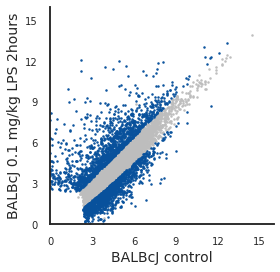

In [13]:
fig, ax = plt.subplots(1,1,
                        figsize=(4,4),
                        sharex=True,
                        sharey=True)
plt.subplots_adjust(wspace=0.2,
                    hspace=0.2)

# set count for labeling axes
count=0

for comp, grep, labs, color in zip(comps, ids, labels, colors):
    print(comp)
    de, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        './differential/'+comp,
        './expression/HOMER.rawTPM.txt',
        gene_name_index=True)
    
    # extract columns
    g0 = tpm_mat.columns.str.contains(grep[0])
    g1 = tpm_mat.columns.str.contains(grep[1])
    col = g0 | g1
    
    de['logtpm'] = np.log2(tpm_mat.loc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.padj + 10**(-50))
    de['g0_mean'] = np.log2(tpm_mat.loc[:, g0].mean(1)+1)
    de['g1_mean'] = np.log2(tpm_mat.loc[:, g1].mean(1)+1)
       
    # plot group by group scatter:
    de_nonsig = de.reindex(de.index[((de.padj >= pthresh) | (np.abs(de.log2FoldChange) <= lfcthresh[0]))])
    de_sig_fc1 = de.reindex(de.index[(de.padj < pthresh) & (np.abs(de.log2FoldChange) >= lfcthresh[0])])
    
    # check number of peaks in each group
    print(de_nonsig.shape[0], 'peaks')
    print((de_sig_fc1.log2FoldChange > lfcthresh[0]).sum(), 'genes up in group 1')
    print((de_sig_fc1.log2FoldChange < -lfcthresh[0]).sum(), 'genes up in group 2')
    
    for df, c in zip([de_nonsig, de_sig_fc1],
                     color):
        ax.scatter(
            x=df.g0_mean,
            y=df.g1_mean,
            c=c,
            s=dotsize,
            #rasterized=True
        )
     
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    

    ax.set_xlabel(labs[0], fontsize=labelsize+4)
    ax.set_ylabel(labs[1], fontsize=labelsize+4)
    
    #set max and min
    ax.set_xlim([0,ax_max])
    ax.set_ylim([0,ax_max])
    
    # set ticks
    ax.set_xticks(np.arange(0,ax_max,ytickstep))
    ax.set_xticklabels(np.arange(0,ax_max,ytickstep),
                       fontdict={'fontsize':labelsize})
    ax.set_yticks(np.arange(0,ax_max,ytickstep))
    ax.set_yticklabels(np.arange(0,ax_max,ytickstep),
                       fontdict={'fontsize':labelsize})
    
    count = count + 1
# plt.savefig('./figures/'+filename, bbox_inches='tight')

## Write differential genes to list for metascape

In [18]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

In [19]:
log2fc = np.log2(2)
pval = 0.05
gene_list_dict ={}

In [20]:
for i in np.sort(glob.glob('./differential/c57*c57*homer.txt')):
    print(i)
    # read in gene expression data
    df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        depath=i,
        gepath='./expression/HOMER.rawTPM.txt',
        gene_name_index=True)

    # select differential genes
    df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('.')[3]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))

for i in np.sort(glob.glob('./differential/balb*balb*homer.txt')):
    print(i)
    # read in gene expression data
    df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        depath=i,
        gepath='./expression/HOMER.rawTPM.txt',
        gene_name_index=True)

    # select differential genes
    df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('.')[3]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))
    
for i in np.sort(glob.glob('./differential/aj*aj*homer.txt')):
    print(i)
    # read in gene expression data
    df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        depath=i,
        gepath='./expression/HOMER.rawTPM.txt',
        gene_name_index=True)

    # select differential genes
    df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('.')[3]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))

./differential/balbc_kupffer_control.vs.balbc_kupffer_lps_2hours.scatter.homer.txt
ge all transcripts (24940, 14)
Diff Gene selected transcripts (9132, 14)
ge selected transcripts (9132, 14)
./differential/balbc_kupffer_lps_2hours.vs.balbc_kupffer_control.scatter.homer.txt
ge all transcripts (24940, 14)
Diff Gene selected transcripts (9132, 14)
ge selected transcripts (9132, 14)


In [21]:
for key in gene_list_dict.keys():
    print(key)
    print(len(gene_list_dict[key]), 'genes')
    with open('./gene_lists/'+key+'_kupffer_genes_fc_%.2f_pval_%.2f_.txt' % (log2fc, pval), 'w') as f:
        f.write('Gene\n')
        for i in gene_list_dict[key]:
            f.write(i+'\n')
        f.close()

balbc_kupffer_lps_2hours_up
1407 genes
balbc_kupffer_control_up
1381 genes


# How many leptin induced genes are common

In [22]:
# fig, ax = plt.subplots(figsize=(8,8))

# # venn3 accepts a list with the following order
# # (100, 010, 110, 001, 101, 011, 111)
# # group1, group2, group1+2, group3, group1+3, group2+3, group3
# venn2(subsets=[# set(gene_list_dict['c57_wholeliver_leptin_6hours_up']),
#                set(gene_list_dict['balbc_kupffer_leptin_6hours_up']),
#                set(gene_list_dict['aj_kupffer_leptin_6hours_up'])],
#      ax=ax,
#      set_colors=(# '#006d2c',
#                  '#08519c', '#de2d26'),
#      set_labels=(# 'C57',
#                  'BALBC', 'AJ'),
#      alpha=0.5)
# ax.set_title('leptin Activated wholeliver Genes');

# plt.savefig('./figures/venn2_activated_genes.png', bbox_inches='tight')

In [23]:
# fig, ax = plt.subplots(figsize=(8,8))

# # venn3 accepts a list with the following order
# # (100, 010, 110, 001, 101, 011, 111)
# # group1, group2, group1+2, group3, group1+3, group2+3, group3
# venn2(subsets=[# set(gene_list_dict['c57_wholeliver_control_young_up']),
#                set(gene_list_dict['balbc_kupffer_control_up']),
#                set(gene_list_dict['aj_kupffer_control_up'])],
#      ax=ax,
#      set_colors=(# '#006d2c',
#                  '#08519c', '#de2d26'),
#      set_labels=(# 'C57',
#                  'BALBC', 'AJ'),
#      alpha=0.5)
# ax.set_title('leptin repressed wholeliver Genes');

# plt.savefig('./figures/venn2_activated_genes.png', bbox_inches='tight')

### Pull sets for manual examination

activated genes

In [24]:
# all3 = set(gene_list_dict['aj_wholeliver_leptin_6hours_up']).intersection(set(gene_list_dict['balbc_wholeliver_leptin_6hours_up']).intersection(gene_list_dict['c57_wholeliver_leptin_6hours_up']))
# C57_balbc = set(gene_list_dict['c57_wholeliver_leptin_6hours_up']).intersection(set(gene_list_dict['balbc_wholeliver_leptin_6hours_up']).difference(all3))
# C57_aj = set(gene_list_dict['c57_wholeliver_leptin_6hours_up']).intersection(set(gene_list_dict['aj_wholeliver_leptin_6hours_up']).difference(all3))
# balbc_aj = set(gene_list_dict['balbc_wholeliver_leptin_6hours_up']).intersection(gene_list_dict['aj_wholeliver_leptin_6hours_up']).difference(all3)
# C57_private = set(gene_list_dict['c57_wholeliver_leptin_6hours_up']).difference(set(all3).union(set(C57_balbc).union(C57_aj)))
# balbc_private = set(gene_list_dict['balbc_wholeliver_leptin_6hours_up']).difference(set(all3).union(set(C57_balbc).union(balbc_aj)))
# aj_private = set(gene_list_dict['aj_wholeliver_leptin_6hours_up']).difference(set(all3).union(set(C57_aj).union(balbc_aj)))

In [25]:
# genesets = [aj_private, C57_private, balbc_private]
# genesetnames = ['aj_private', 'c57_private', 'balbc_private']
# for listname, genelist in zip(genesetnames, genesets):
#     with open('./gene_lists/'+listname+'_wholeliver_genes_fc_'+str(log2fc)+'_pval_'+str(pval)+'.txt', 'w') as f:
#         f.write('Gene\n')
#         for i in genelist:
#             f.write(i+'\n')
#         f.close()

# Plot specific genes as barplots

In [26]:
tpm_mat = pd.read_csv('./expression/rawT.txt', sep='\t', index_col=0)

In [27]:
tpm_mat.columns

Index(['c57_kupffer_control_C5701C', 'c57_kupffer_control_C5701D',
       'c57_kupffer_lps_2hours_2A', 'balbc_kupffer_control_BALB01C',
       'balbc_kupffer_control_BALB01D', 'balbc_kupffer_lps_2hours_1A',
       'balbc_kupffer_lps_2hours_1B'],
      dtype='object')

In [28]:
from matplotlib.patches import Patch

In [29]:
groups = [[0,1],
          [2],
          [3,4],
          [5,6]]

group_labels = ['C57BL/6J Kupffer Control young',
                'C57BL/6J Kupffer leptin 6 hours',
                'Balb/cJ Kupffer Control young',
                'Balb/cJ Kupffer leptin 6 hours']

colors = ['#74c476',
          '#006d2c',
          '#6baed6',
          '#08519c']

legend_elements = []
for lab, col in  zip(group_labels, colors):
    legend_elements.append(Patch(label=lab, color=col))

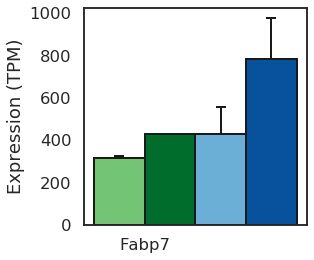

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))

gene_list_bar_plot(['Fabp7'],
                   tpm_mat,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width = 0.15,
                   ax=ax)

ax.get_legend().remove()

[]

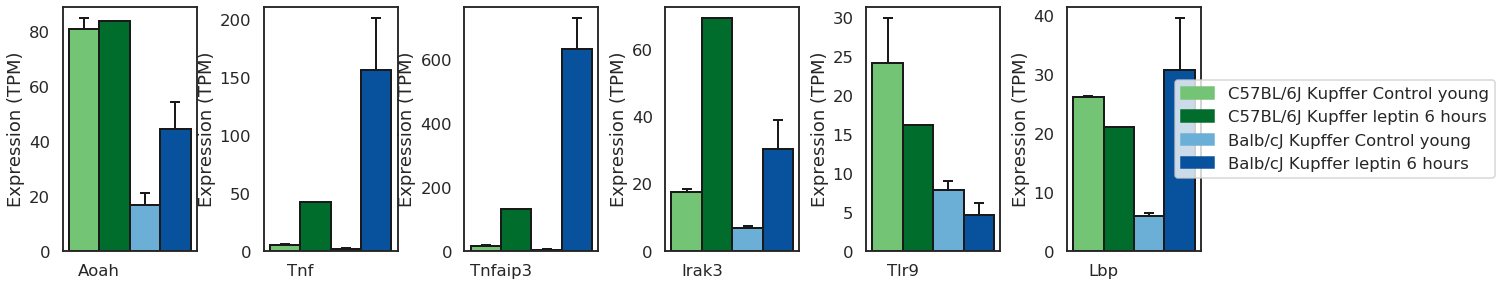

In [31]:
gene_list = ['Aoah', 'Tnf', 'Tnfaip3', 'Irak3', 'Tlr9', 'Lbp']

fig, axs = plt.subplots(1, len(gene_list)+1, figsize=(4*len(gene_list), 3*len(gene_list)/4))
plt.subplots_adjust(wspace=0.5)


for gene, ax in zip(gene_list, axs.flat):
    gene_list_bar_plot([gene],
                       tpm_mat,
                       groups=groups,
                       group_labels = group_labels,
                       colors = colors,
                       width = 0.15,
                       ax=ax)

    ax.get_legend().remove()
    
axs.flat[-1].legend(handles=legend_elements, loc='center')
axs.flat[-1].spines['top'].set_visible(False)
axs.flat[-1].spines['right'].set_visible(False)
axs.flat[-1].spines['left'].set_visible(False)
axs.flat[-1].spines['bottom'].set_visible(False)
axs.flat[-1].set_xticklabels('')
axs.flat[-1].set_yticklabels('')

# Fisher exact test of overlap between C57 trans genes and genes induced by LPS in BALBcJ mice.

Read in balbcj differential data

In [32]:
de, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
    './differential/balbc_kupffer_control.vs.balbc_kupffer_lps_2hours.scatter.homer.txt',
    './expression/HOMER.rawTPM.txt',
    gene_name_index=True)

ge all transcripts (24940, 14)
Diff Gene selected transcripts (9132, 14)
ge selected transcripts (9132, 14)


Read in gene list for c57 trans genes

In [33]:
with open('/home/h1bennet/strains_rna/results/K03_CB6F1_Kupffer_RNA/gene_lists/cb6f1_kupffer_trans_c57_filt.txt', 'r') as f:
    c57_trans = [i.strip() for i in f.readlines()[1:]]

In [34]:
print(len(gene_list_dict['balbc_kupffer_lps_2hours_up']), 'genes up in Balb KC + LPS')
print(len(c57_trans), 'C57 trans regulated genes')
print(len(set(gene_list_dict['balbc_kupffer_lps_2hours_up']).intersection(c57_trans)), 'shared')

1407 genes up in Balb KC + LPS
66 C57 trans regulated genes
29 shared


Contingency table explained:  

genes in dataset: 9132  
genes 2 fold up in balb LPS treatment: 1407  
C57 Trans Genes: 66  
overlap between two gene sets: 29.  

|  |Not in A              | in A |
|:---:|:----------------------:|:-----:
Not in B|9132 - 1407 - 66 | 66-29
In B|1407-29                | 29

In [37]:
stats.fisher_exact([[9132 - 1407 - 66, 66-29], [1407-29, 29]], alternative='greater')

(4.356313497822931, 3.037360128035335e-08)

Test converse

In [40]:
print(len(gene_list_dict['balbc_kupffer_control_up']), 'genes down in Balb KC + LPS')
print(len(c57_trans), 'C57 trans regulated genes')
print(len(set(gene_list_dict['balbc_kupffer_control_up']).intersection(c57_trans)), 'shared')

1381 genes down in Balb KC + LPS
34 C57 trans regulated genes
0 shared


Contingency table explained:  

genes in dataset: 9132  
genes 2 fold down in balb LPS treatment: 1381  
C57 Trans Genes: 34  
overlap between two gene sets: 0.  

|  |Not in A              | in A |
|:---:|:----------------------:|:-----:
Not in B|9132 - 1381 - 0 | 66-0
In B|1381-0                | 0

In [41]:
stats.fisher_exact([[9132 - 1381 - 0, 34-0], [1381-0, 0]], alternative='greater')

(0.0, 1.0)

In [36]:
with open('/home/h1bennet/strains_rna/results/K03_CB6F1_Kupffer_RNA/gene_lists/cb6f1_kupffer_trans_c57_filt_pval.txt', 'r') as f:
    c57_trans = [i.strip() for i in f.readlines()[1:]]

In [33]:
print(len(gene_list_dict['balbc_kupffer_lps_2hours_up']), 'genes up in Balb KC + LPS')
print(len(c57_trans), 'C57 trans regulated genes')
print(len(set(gene_list_dict['balbc_kupffer_lps_2hours_up']).intersection(c57_trans)), 'shared')

1407 genes up in Balb KC + LPS
61 C57 trans regulated genes
26 shared


In [35]:
stats.fisher_exact([[9132 - 1407 - 61, 61-26], [1407-26, 26]], alternative='greater')

(4.122561290989966, 3.262484042320674e-07)

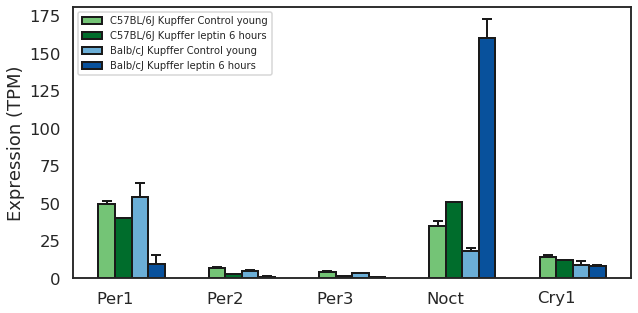

In [71]:
fig, ax = plt.subplots(figsize=(10, 5))

gene_list_bar_plot(['Per1', 'Per2', 'Per3', 'Noct', 'Cry1'],
                   tpm_mat,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width = 0.15,
                   ax=ax)

# ax.get_legend().remove()